In [1]:
# Packages / libraries
import os #provides functions for interacting with the operating system
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

import graphviz
from sklearn import tree

# remove warnings
import warnings

# Suppress specific warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, module='pandas.io.formats.format')

# **1. Loading Dataset**

In [2]:
# Loading the data
new_data = pd.read_csv("/kaggle/input/seperated-data/Pakistan_Lahore.csv")

# print the shape
print(new_data.shape)

#runs the first 5 rows
new_data.head()

(1570, 12)


,Date,co,no2,o3,pm10,pm25,so2,humidity,pressure,temperature,wind-speed,Country_City
0,2019-05-09,NaN,NaN,NaN,NaN,196.0,NaN,20.0,1003.0,33.0,2.3,Pakistan_Lahore
1,2019-05-10,NaN,NaN,NaN,NaN,159.0,NaN,28.0,1004.0,32.0,3.6,Pakistan_Lahore
2,2019-05-11,NaN,NaN,NaN,NaN,197.0,NaN,43.0,1007.0,29.0,3.0,Pakistan_Lahore
3,2019-05-12,NaN,NaN,NaN,NaN,176.0,NaN,37.0,1006.0,31.0,2.5,Pakistan_Lahore
4,2019-05-13,NaN,NaN,NaN,NaN,171.0,NaN,51.0,1005.0,28.0,2.5,Pakistan_Lahore


In [3]:
# Find the minimum and maximum dates
min_date = new_data['Date'].min()
max_date = new_data['Date'].max()

print('Minimum date:', min_date)
print('Maximum date:', max_date)

Minimum date: 2019-05-09
Maximum date: 2025-01-09


In [4]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570 entries, 0 to 1569
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1570 non-null   object 
 1   co            0 non-null      float64
 2   no2           0 non-null      float64
 3   o3            0 non-null      float64
 4   pm10          0 non-null      float64
 5   pm25          1570 non-null   float64
 6   so2           0 non-null      float64
 7   humidity      1546 non-null   float64
 8   pressure      1546 non-null   float64
 9   temperature   1546 non-null   float64
 10  wind-speed    1452 non-null   float64
 11  Country_City  1570 non-null   object 
dtypes: float64(10), object(2)
memory usage: 147.3+ KB


In [5]:
new_data.describe()

,co,no2,o3,pm10,pm25,so2,humidity,pressure,temperature,wind-speed
count,0.0,0.0,0.0,0.0,1570.000000,0.0,1546.000000,1546.000000,1546.000000,1452.000000
mean,NaN,NaN,NaN,NaN,177.652229,NaN,60.527814,1008.290944,24.336869,2.848829
std,NaN,NaN,NaN,NaN,83.876598,NaN,16.844766,7.182917,8.097599,1.260782
min,NaN,NaN,NaN,NaN,5.000000,NaN,18.000000,992.000000,6.000000,0.500000
25%,NaN,NaN,NaN,NaN,127.000000,NaN,50.000000,1002.000000,18.000000,2.000000
50%,NaN,NaN,NaN,NaN,159.000000,NaN,62.000000,1008.000000,26.500000,2.500000
75%,NaN,NaN,NaN,NaN,196.000000,NaN,72.000000,1015.000000,30.500000,3.600000
max,NaN,NaN,NaN,NaN,568.000000,NaN,100.000000,1024.000000,39.000000,8.700000


In [6]:
# Investigate all the elements whithin each Feature

for column in new_data:
    # Handle numerical and string columns differently
    if new_data[column].dtype == 'object':  # Check if column is of object type
        unique_vals = new_data[column].unique()  # pandas unique for strings
    else:
        unique_vals = np.unique(new_data[column])  # numpy unique for numerical types

    nr_values = len(unique_vals)
    if nr_values < 14:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature Date :1569
The number of values for feature co :1 -- [nan]
The number of values for feature no2 :1 -- [nan]
The number of values for feature o3 :1 -- [nan]
The number of values for feature pm10 :1 -- [nan]
The number of values for feature pm25 :324
The number of values for feature so2 :1 -- [nan]
The number of values for feature humidity :153
The number of values for feature pressure :76
The number of values for feature temperature :78
The number of values for feature wind-speed :41
The number of values for feature Country_City :1 -- ['Pakistan_Lahore']


In [7]:
new_data.isna().sum()

Date               0
co              1570
no2             1570
o3              1570
pm10            1570
pm25               0
so2             1570
humidity          24
pressure          24
temperature       24
wind-speed       118
Country_City       0
dtype: int64

# **1.2 - Function -- Preprocessing**

In [8]:
#Convert into datatime index
def prepare_datetime_index(df, date_column='Date'):
    """Convert date column to datetime and set as index."""
    df = df.copy()
    df[date_column] = pd.to_datetime(df[date_column])
    df = df.drop_duplicates(subset=[date_column], keep='last')
    df.set_index(date_column, inplace=True)
    return df

In [9]:
# Call the functions
new_data1 = prepare_datetime_index(new_data, date_column='Date')
new_data1.head()

,co,no2,o3,pm10,pm25,so2,humidity,pressure,temperature,wind-speed,Country_City
Date,,,,,,,,,,,
2019-05-09,NaN,NaN,NaN,NaN,196.0,NaN,20.0,1003.0,33.0,2.3,Pakistan_Lahore
2019-05-10,NaN,NaN,NaN,NaN,159.0,NaN,28.0,1004.0,32.0,3.6,Pakistan_Lahore
2019-05-11,NaN,NaN,NaN,NaN,197.0,NaN,43.0,1007.0,29.0,3.0,Pakistan_Lahore
2019-05-12,NaN,NaN,NaN,NaN,176.0,NaN,37.0,1006.0,31.0,2.5,Pakistan_Lahore
2019-05-13,NaN,NaN,NaN,NaN,171.0,NaN,51.0,1005.0,28.0,2.5,Pakistan_Lahore


In [10]:
new_data1.columns

Index(['co', 'no2', 'o3', 'pm10', 'pm25', 'so2', 'humidity', 'pressure',
       'temperature', 'wind-speed', 'Country_City'],
      dtype='object')

In [11]:
# Drop collumns which have large quantity of missing value and of no use
new_data2 = new_data1.drop(['co', 'no2', 'o3', 'pm10', 'so2', 'Country_City'], axis= 1)

In [12]:
new_data2.isna().sum()

pm25             0
humidity        24
pressure        24
temperature     24
wind-speed     118
dtype: int64

In [13]:
# Fill the missing value 

imputer = SimpleImputer(strategy="mean")

# Select the columns
columns_to_impute = ['humidity', 'pressure', 'temperature', 'wind-speed']

new_data2[columns_to_impute] = imputer.fit_transform(new_data2[columns_to_impute])

**Check**

In [14]:
new_data2.isna().sum()

pm25           0
humidity       0
pressure       0
temperature    0
wind-speed     0
dtype: int64

In [15]:
# Create a complete range of dates
full_range = pd.date_range(start=new_data2.index.min(), end=new_data2.index.max())

# Find missing dates
missing_dates = full_range.difference(new_data2.index)
print("Missing Dates:")
print(missing_dates)

Missing Dates:
DatetimeIndex(['2019-10-05', '2019-10-06', '2020-05-03', '2020-07-05',
               '2021-03-31', '2021-05-15', '2021-05-16', '2021-06-26',
               '2021-06-28', '2021-06-29',
               ...
               '2024-06-20', '2024-06-21', '2024-06-22', '2024-06-23',
               '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27',
               '2024-06-28', '2024-06-29'],
              dtype='datetime64[ns]', length=504, freq=None)


In [16]:
#Function for imputing missing dates
def impute_missing_dates(df):
    """Handle missing dates and duplicates in the time series."""
    df = df.copy()
    
    # Create full date range
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    
    # Reindex to include missing dates
    df = df.reindex(full_range)
    
    # Fill missing values using forward fill
    df = df.ffill()
    
    # Drop any duplicates and sort by index
    df = df[~df.index.duplicated(keep='last')].sort_index()
    
    return df

In [17]:
new_data3 = impute_missing_dates(new_data2)

In [18]:
# Create a complete range of dates
full_range = pd.date_range(start=new_data3.index.min(), end=new_data3.index.max())

# Find missing dates
missing_dates = full_range.difference(new_data3.index)
print("Missing Dates:")
print(missing_dates)

Missing Dates:
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [19]:
duplicates = new_data3.index[new_data3.index.duplicated()]
print(f"Duplicate indexes: {duplicates}")

Duplicate indexes: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


# **1.3.Normal AQI count**

In [20]:
#Normal AQI count Function
def calculate_aqi(data, subindex_columns=None):
    """Calculate Air Quality Index based on available pollutants."""
    data = data.copy()
    
    # Determine available pollutant columns
    if subindex_columns is None:
        all_possible_columns = ['co', 'no2', 'o3', 'pm10', 'pm25', 'so2']
        subindex_columns = [col for col in all_possible_columns if col in data.columns]
    
    # Skip if no pollutant columns are available
    if not subindex_columns:
        print(f"Warning: No pollutant columns available for {data.index}. Skipping record.")
        return None
    
    # Calculate AQI as maximum value among available pollutants
    data["AQI"] = data[subindex_columns].max(axis=1)
    data["AQI"] = data["AQI"].round()
    
    return data

In [21]:
new_data4 = calculate_aqi(new_data3)

In [22]:
new_data4.head()

,pm25,humidity,pressure,temperature,wind-speed,AQI
2019-05-09,196.0,20.0,1003.0,33.0,2.3,196.0
2019-05-10,159.0,28.0,1004.0,32.0,3.6,159.0
2019-05-11,197.0,43.0,1007.0,29.0,3.0,197.0
2019-05-12,176.0,37.0,1006.0,31.0,2.5,176.0
2019-05-13,171.0,51.0,1005.0,28.0,2.5,171.0


<Axes: >

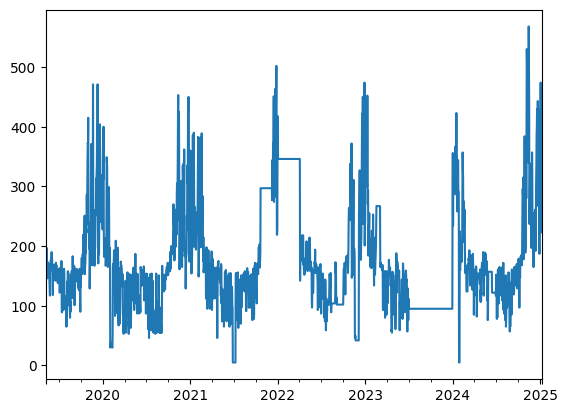

In [23]:
norm_aqi = new_data4['AQI']
norm_aqi.plot()

# **1.4. Smooth AQI count (Preprocess Pollution(outlier handling-IQR) --> Smooth Pollution --> Calculate smooth aqi).**

In [24]:
def handle_aqi_outliers(series, method='iqr'):
    """Handle outliers in AQI data."""
    if method == 'iqr':
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return series.clip(lower=lower_bound, upper=upper_bound)
    elif method == 'rolling':
        return series.rolling(window=3, center=True, min_periods=1).median()
    return series

In [25]:
def calculate_smooth_aqi(df):
    """Calculate smoothed AQI based on available pollutants."""
    df_processed = df.copy()
    
    # Get available pollutant columns
    pollutant_columns = [col for col in ['co', 'no2', 'o3', 'pm10', 'pm25', 'so2'] 
                        if col in df.columns]
    
    if not pollutant_columns:
        raise ValueError("No pollutant columns available for AQI calculation")
    
    # Preprocess available components
    for col in pollutant_columns:
        df_processed[col] = handle_aqi_outliers(df_processed[col], method='iqr')
        df_processed[col] = (df_processed[col]
                           .rolling(window=6, center=True)
                           .mean()
                           .ffill()
                           .bfill())
    
    # Calculate smooth AQI
    smooth_aqi = df_processed[pollutant_columns].max(axis=1)
    smooth_aqi = handle_aqi_outliers(smooth_aqi, method='rolling')
    
    df_processed['AQI_Smooth'] = smooth_aqi
    
    return df_processed

In [26]:
new_smooth = calculate_smooth_aqi(new_data3)
new_smooth.head()

,pm25,humidity,pressure,temperature,wind-speed,AQI_Smooth
2019-05-09,174.166667,20.0,1003.0,33.0,2.3,174.166667
2019-05-10,174.166667,28.0,1004.0,32.0,3.6,174.166667
2019-05-11,174.166667,43.0,1007.0,29.0,3.0,174.166667
2019-05-12,174.166667,37.0,1006.0,31.0,2.5,174.166667
2019-05-13,170.166667,51.0,1005.0,28.0,2.5,172.500000


<Axes: >

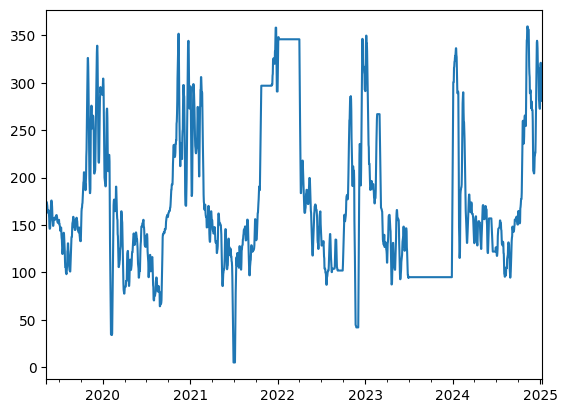

In [27]:
smooth_aqi = new_smooth['AQI_Smooth']
smooth_aqi.plot()

# **2.1. Splitting & Preprocessing the Raw Data(Normal AQI)**

Normal AQI

In [28]:
new_data4.head()

,pm25,humidity,pressure,temperature,wind-speed,AQI
2019-05-09,196.0,20.0,1003.0,33.0,2.3,196.0
2019-05-10,159.0,28.0,1004.0,32.0,3.6,159.0
2019-05-11,197.0,43.0,1007.0,29.0,3.0,197.0
2019-05-12,176.0,37.0,1006.0,31.0,2.5,176.0
2019-05-13,171.0,51.0,1005.0,28.0,2.5,171.0


In [29]:
new_data4.columns

Index(['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed', 'AQI'], dtype='object')

***Working with Normal AQI***

In [30]:
data = new_data4.copy()

In [31]:
data.head()

,pm25,humidity,pressure,temperature,wind-speed,AQI
2019-05-09,196.0,20.0,1003.0,33.0,2.3,196.0
2019-05-10,159.0,28.0,1004.0,32.0,3.6,159.0
2019-05-11,197.0,43.0,1007.0,29.0,3.0,197.0
2019-05-12,176.0,37.0,1006.0,31.0,2.5,176.0
2019-05-13,171.0,51.0,1005.0,28.0,2.5,171.0


In [32]:
num = data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
cat = data.select_dtypes(include=['object'])

print(num.columns)
print(cat.columns)

Index(['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed', 'AQI'], dtype='object')
Index([], dtype='object')


In [33]:
X = data[['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed']]

y = data['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1658, 5) (1658,) (415, 5) (415,)


In [34]:
# Preprocessor without scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed'])
    ])
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# **2.2. Model Training & Testing**

## **2.2.1. LinearRegression**

In [35]:
# training with LinearRegression

lm = LinearRegression(fit_intercept = True)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', lm)])

# Fit the pipeline to the training data
pipeline.fit(X_train,y_train)

# Predict on the training and test datasets
y_pred_train_lm = pipeline.predict(X_train)
y_pred_test_lm = pipeline.predict(X_test)

In [36]:
# Model Accuracy on training and testing dataset

print('The r2 Accuracy on the training dataset prediction is: ',r2_score(y_train,y_pred_train_lm) )
print('The r2 Accuracy on the test dataset prediction is: ',r2_score(y_test,y_pred_test_lm) )

print("")

# The Root Mean Squared Error (RMSE)
print('The RMSE  on the training dataset is: ',sqrt(mean_squared_error(y_train, y_pred_train_lm)))
print('The RMSE  on the testing dataset is: ',sqrt(mean_squared_error(y_test, y_pred_test_lm)))

print("")
# The Mean Absolute Error (MAE)
print('The MAE  on the training dataset is: ',mean_absolute_error(y_train, y_pred_train_lm))
print('The MAE  on the testing dataset is: ',mean_absolute_error(y_test, y_pred_test_lm))

print("")
# The Mean Squared Error (MSE)
print('The MSE  on the training dataset is: ',mean_squared_error(y_train, y_pred_train_lm))
print('The MSE  on the testing dataset is: ',mean_squared_error(y_test, y_pred_test_lm))

The r2 Accuracy on the training dataset prediction is:  1.0
The r2 Accuracy on the test dataset prediction is:  1.0

The RMSE  on the training dataset is:  7.635264772032994e-14
The RMSE  on the testing dataset is:  8.107987846512235e-14

The MAE  on the training dataset is:  6.09543242846794e-14
The MAE  on the testing dataset is:  6.676747508285495e-14

The MSE  on the training dataset is:  5.829726813904804e-27
The MSE  on the testing dataset is:  6.573946691919012e-27


## **2.2.2.  KNeighborsRegressor**

In [37]:
# training with KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=2)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', neigh)])

# Fit the pipeline to the training data
pipeline.fit(X_train,y_train)

# Predict on the training and test datasets
y_pred_train_knn = pipeline.predict(X_train)
y_pred_test_knn = pipeline.predict(X_test)

In [38]:
# Model Accuracy on training dataset
print('The R2 score on the training dataset prediction is: ', r2_score(y_train,y_pred_train_knn))
print('The R2 score on the test dataset prediction is: ', r2_score(y_test, y_pred_test_knn))
print("")

# The Root Mean Squared Error (RMSE)
print('The RMSE  on the training dataset is: ',sqrt(mean_squared_error(y_train,y_pred_train_knn)))
print('The RMSE  on the testing dataset is: ',sqrt(mean_squared_error(y_test, y_pred_test_knn)))

print("")
# The Mean Absolute Error (MAE)
print('The MAE  on the training dataset is: ',mean_absolute_error(y_train,y_pred_train_knn))
print('The MAE  on the testing dataset is: ',mean_absolute_error(y_test, y_pred_test_knn))

print("")
# The Mean Squared Error (MSE)
print('The MSE  on the training dataset is: ',mean_squared_error(y_train, y_pred_train_knn))
print('The MSE  on the testing dataset is: ',mean_squared_error(y_test, y_pred_test_knn))

The R2 score on the training dataset prediction is:  0.9998023517693524
The R2 score on the test dataset prediction is:  0.9989554149419444

The RMSE  on the training dataset is:  1.2491251462045663
The RMSE  on the testing dataset is:  3.0459334929334054

The MAE  on the training dataset is:  0.7515078407720145
The MAE  on the testing dataset is:  1.297590361445783

The MSE  on the training dataset is:  1.560313630880579
The MSE  on the testing dataset is:  9.277710843373494


## **2.2.3.  Random Forest Regressor**

In [39]:
# Training with random forest regressor
random = RandomForestRegressor()

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', random)])

# Fit the pipeline to the training data
pipeline.fit(X_train,y_train)

# Predict on the training and test datasets
y_pred_train_random = pipeline.predict(X_train)
y_pred_test_random = pipeline.predict(X_test)

In [40]:
# Model Accuracy on training dataset
print('The R2 score on the training dataset prediction is: ', r2_score(y_train,y_pred_train_random))
print('The R2 score on the test dataset prediction is: ', r2_score(y_test, y_pred_test_random))
print("")

# The Root Mean Squared Error (RMSE)
print('The RMSE  on the training dataset is: ',sqrt(mean_squared_error(y_train,y_pred_train_random)))
print('The RMSE  on the testing dataset is: ',sqrt(mean_squared_error(y_test, y_pred_test_random)))

print("")
# The Mean Absolute Error (MAE)
print('The MAE  on the training dataset is: ',mean_absolute_error(y_train,y_pred_train_random))
print('The MAE  on the testing dataset is: ',mean_absolute_error(y_test, y_pred_test_random))

print("")
# The Mean Squared Error (MSE)
print('The MSE  on the training dataset is: ',mean_squared_error(y_train, y_pred_train_random))
print('The MSE  on the testing dataset is: ',mean_squared_error(y_test, y_pred_test_random))

The R2 score on the training dataset prediction is:  0.999981938168182
The R2 score on the test dataset prediction is:  0.9989393535225504

The RMSE  on the training dataset is:  0.3776073010733305
The RMSE  on the testing dataset is:  3.0692611253234365

The MAE  on the training dataset is:  0.07984921592279877
The MAE  on the testing dataset is:  0.3493493975903607

The MSE  on the training dataset is:  0.1425872738238849
The MSE  on the testing dataset is:  9.420363855421687


## **2.2.4.  Decision Tree regressor**

In [41]:
# Training with Decision Tree regressor
dt = DecisionTreeRegressor()

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', dt)])

# Fit the pipeline to the training data
pipeline.fit(X_train,y_train)

# Predict on the training and test datasets
y_pred_train_dt = pipeline.predict(X_train)
y_pred_test_dt = pipeline.predict(X_test)

In [42]:
# Model Accuracy on training dataset
print('The R2 score on the training dataset prediction is: ', r2_score(y_train,y_pred_train_dt))
print('The R2 score on the test dataset prediction is: ', r2_score(y_test, y_pred_test_dt))
print("")

# The Root Mean Squared Error (RMSE)
print('The RMSE  on the training dataset is: ',sqrt(mean_squared_error(y_train,y_pred_train_dt)))
print('The RMSE  on the testing dataset is: ',sqrt(mean_squared_error(y_test, y_pred_test_dt)))

print("")
# The Mean Absolute Error (MAE)
print('The MAE  on the training dataset is: ',mean_absolute_error(y_train,y_pred_train_dt))
print('The MAE  on the testing dataset is: ',mean_absolute_error(y_test, y_pred_test_dt))

print("")
# The Mean Squared Error (MSE)
print('The MSE  on the training dataset is: ',mean_squared_error(y_train, y_pred_train_dt))
print('The MSE  on the testing dataset is: ',mean_squared_error(y_test, y_pred_test_dt))

The R2 score on the training dataset prediction is:  1.0
The R2 score on the test dataset prediction is:  0.9994948334840337

The RMSE  on the training dataset is:  0.0
The RMSE  on the testing dataset is:  2.1181942753089973

The MAE  on the training dataset is:  0.0
The MAE  on the testing dataset is:  0.327710843373494

The MSE  on the training dataset is:  0.0
The MSE  on the testing dataset is:  4.486746987951808


## **2.2.5.  Support Vector Machine regressor**

In [43]:
# Training with Support Vector Machine regressor
svr = SVR(kernel='linear')

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', svr)])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict on the training and test datasets
y_pred_train_svr = pipeline.predict(X_train)
y_pred_test_svr = pipeline.predict(X_test)

In [44]:
# Model Accuracy on training dataset
print('The R2 score on the training dataset prediction is: ', r2_score(y_train, y_pred_train_svr))
print('The R2 score on the test dataset prediction is: ', r2_score(y_test, y_pred_test_svr))
print("")

# The Root Mean Squared Error (RMSE)
print('The RMSE on the training dataset is: ', sqrt(mean_squared_error(y_train, y_pred_train_svr)))
print('The RMSE on the testing dataset is: ', sqrt(mean_squared_error(y_test, y_pred_test_svr)))
print("")

# The Mean Absolute Error (MAE)
print('The MAE on the training dataset is: ', mean_absolute_error(y_train, y_pred_train_svr))
print('The MAE on the testing dataset is: ', mean_absolute_error(y_test, y_pred_test_svr))

print("")
# The Mean Squared Error (MSE)
print('The MSE  on the training dataset is: ',mean_squared_error(y_train, y_pred_train_svr))
print('The MSE  on the testing dataset is: ',mean_squared_error(y_test, y_pred_test_svr))

The R2 score on the training dataset prediction is:  0.9999997232515452
The R2 score on the test dataset prediction is:  0.9999997399772302

The RMSE on the training dataset is:  0.04674144003181773
The RMSE on the testing dataset is:  0.048056728421015445

The MAE on the training dataset is:  0.04126119312296478
The MAE on the testing dataset is:  0.04247680272950786

The MSE  on the training dataset is:  0.0021847622162480132
The MSE  on the testing dataset is:  0.0023094491465312336


## **2.2.6.  XGBoost Regressor**

In [45]:
# Training with XGBoost regressor
xgb_regressor = XGBRegressor(objective='reg:squarederror')

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', xgb_regressor)])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict on the training and test datasets
y_pred_train_xgb = pipeline.predict(X_train)
y_pred_test_xgb = pipeline.predict(X_test)

In [46]:
# Model Accuracy on training dataset
print('The R2 score on the training dataset prediction is: ', r2_score(y_train, y_pred_train_xgb))
print('The R2 score on the test dataset prediction is: ', r2_score(y_test, y_pred_test_xgb))
print("")

# The Root Mean Squared Error (RMSE)
print('The RMSE on the training dataset is: ', sqrt(mean_squared_error(y_train, y_pred_train_xgb)))
print('The RMSE on the testing dataset is: ', sqrt(mean_squared_error(y_test, y_pred_test_xgb)))
print("")

# The Mean Absolute Error (MAE)
print('The MAE on the training dataset is: ', mean_absolute_error(y_train, y_pred_train_xgb))
print('The MAE on the testing dataset is: ', mean_absolute_error(y_test, y_pred_test_xgb))

print("")
# The Mean Squared Error (MSE)
print('The MSE  on the training dataset is: ',mean_squared_error(y_train, y_pred_train_xgb))
print('The MSE  on the testing dataset is: ',mean_squared_error(y_test, y_pred_test_xgb))

The R2 score on the training dataset prediction is:  0.9999975633210375
The R2 score on the test dataset prediction is:  0.9981608724256541

The RMSE on the training dataset is:  0.13869430948532485
The RMSE on the testing dataset is:  4.041610337477007

The MAE on the training dataset is:  0.07736054548164616
The MAE on the testing dataset is:  0.8001983780458749

The MSE  on the training dataset is:  0.01923611148361107
The MSE  on the testing dataset is:  16.334614120001007


## **2.2.7.  Neural Network Regressor**

In [47]:
# training with neural network regressor

nn = MLPRegressor(hidden_layer_sizes=(8,), activation='relu', solver='adam', max_iter=2000, learning_rate_init=0.001)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', nn)])

# Fit the pipeline to the training data
pipeline.fit(X_train,y_train)

# Predict on the training and test datasets
y_pred_train_nn = pipeline.predict(X_train)
y_pred_test_nn = pipeline.predict(X_test)

In [48]:
# Model Accuracy on training dataset
print('The R2 score on the training dataset prediction is: ', r2_score(y_train, y_pred_train_nn))
print('The R2 score on the test dataset prediction is: ', r2_score(y_test, y_pred_test_nn))
print("")

# The Root Mean Squared Error (RMSE)
print('The RMSE on the training dataset is: ', sqrt(mean_squared_error(y_train, y_pred_train_nn)))
print('The RMSE on the testing dataset is: ', sqrt(mean_squared_error(y_test, y_pred_test_nn)))
print("")

# The Mean Absolute Error (MAE)
print('The MAE on the training dataset is: ', mean_absolute_error(y_train, y_pred_train_nn))
print('The MAE on the testing dataset is: ', mean_absolute_error(y_test, y_pred_test_nn))

print("")
# The Mean Squared Error (MSE)
print('The MSE  on the training dataset is: ',mean_squared_error(y_train, y_pred_train_nn))
print('The MSE  on the testing dataset is: ',mean_squared_error(y_test, y_pred_test_nn))

The R2 score on the training dataset prediction is:  0.9999994574333063
The R2 score on the test dataset prediction is:  0.9999997606679173

The RMSE on the training dataset is:  0.06544644349610436
The RMSE on the testing dataset is:  0.04610510037342395

The MAE on the training dataset is:  0.029630972940442854
The MAE on the testing dataset is:  0.030891839703707968

The MSE  on the training dataset is:  0.004283236966288781
The MSE  on the testing dataset is:  0.002125680280443497


# **6.1. Splitting & Preprocessing the Raw Data**

(Preprocess Pollution --> Smooth Pollution --> Calculate smooth aqi)

In [49]:
new_smooth.head()

,pm25,humidity,pressure,temperature,wind-speed,AQI_Smooth
2019-05-09,174.166667,20.0,1003.0,33.0,2.3,174.166667
2019-05-10,174.166667,28.0,1004.0,32.0,3.6,174.166667
2019-05-11,174.166667,43.0,1007.0,29.0,3.0,174.166667
2019-05-12,174.166667,37.0,1006.0,31.0,2.5,174.166667
2019-05-13,170.166667,51.0,1005.0,28.0,2.5,172.500000


In [50]:
new_smooth.columns

Index(['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed',
       'AQI_Smooth'],
      dtype='object')

***Working with AQI_smoothed_iqr***

In [51]:
data = new_smooth.copy()

In [52]:
data.head()

,pm25,humidity,pressure,temperature,wind-speed,AQI_Smooth
2019-05-09,174.166667,20.0,1003.0,33.0,2.3,174.166667
2019-05-10,174.166667,28.0,1004.0,32.0,3.6,174.166667
2019-05-11,174.166667,43.0,1007.0,29.0,3.0,174.166667
2019-05-12,174.166667,37.0,1006.0,31.0,2.5,174.166667
2019-05-13,170.166667,51.0,1005.0,28.0,2.5,172.500000


In [53]:
num = data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
cat = data.select_dtypes(include=['object'])

print(num.columns)
print(cat.columns)

Index(['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed',
       'AQI_Smooth'],
      dtype='object')
Index([], dtype='object')


In [54]:
X = data[['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed']]

y = data['AQI_Smooth']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1658, 5) (1658,) (415, 5) (415,)


In [55]:
# Preprocessor without scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed'])
    ])
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# **6.2. Model Training & Testing**

## **6.2.1. LinearRegression**

In [56]:
# training with LinearRegression

lm = LinearRegression(fit_intercept = True)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', lm)])

# Fit the pipeline to the training data
pipeline.fit(X_train,y_train)

# Predict on the training and test datasets
y_pred_train_lm = pipeline.predict(X_train)
y_pred_test_lm = pipeline.predict(X_test)

In [57]:
# Model Accuracy on training and testing dataset

print('The r2 Accuracy on the training dataset prediction is: ',r2_score(y_train,y_pred_train_lm) )
print('The r2 Accuracy on the test dataset prediction is: ',r2_score(y_test,y_pred_test_lm) )

print("")

# The Root Mean Squared Error (RMSE)
print('The RMSE  on the training dataset is: ',sqrt(mean_squared_error(y_train, y_pred_train_lm)))
print('The RMSE  on the testing dataset is: ',sqrt(mean_squared_error(y_test, y_pred_test_lm)))

print("")
# The Mean Absolute Error (MAE)
print('The MAE  on the training dataset is: ',mean_absolute_error(y_train, y_pred_train_lm))
print('The MAE  on the testing dataset is: ',mean_absolute_error(y_test, y_pred_test_lm))

print("")
# The Mean Squared Error (MSE)
print('The MSE  on the training dataset is: ',mean_squared_error(y_train, y_pred_train_lm))
print('The MSE  on the testing dataset is: ',mean_squared_error(y_test, y_pred_test_lm))

The r2 Accuracy on the training dataset prediction is:  0.9994020383046222
The r2 Accuracy on the test dataset prediction is:  0.9992749825850545

The RMSE  on the training dataset is:  1.9075165176662634
The RMSE  on the testing dataset is:  2.1899254574303666

The MAE  on the training dataset is:  0.8002678903166306
The MAE  on the testing dataset is:  0.8094364620470412

The MSE  on the training dataset is:  3.6386192651696283
The MSE  on the testing dataset is:  4.7957735091016


## **6.2.2.  KNeighborsRegressor**

In [58]:
# training with KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=2)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', neigh)])

# Fit the pipeline to the training data
pipeline.fit(X_train,y_train)

# Predict on the training and test datasets
y_pred_train_knn = pipeline.predict(X_train)
y_pred_test_knn = pipeline.predict(X_test)

In [59]:
# Model Accuracy on training dataset
print('The R2 score on the training dataset prediction is: ', r2_score(y_train,y_pred_train_knn))
print('The R2 score on the test dataset prediction is: ', r2_score(y_test, y_pred_test_knn))
print("")

# The Root Mean Squared Error (RMSE)
print('The RMSE  on the training dataset is: ',sqrt(mean_squared_error(y_train,y_pred_train_knn)))
print('The RMSE  on the testing dataset is: ',sqrt(mean_squared_error(y_test, y_pred_test_knn)))

print("")
# The Mean Absolute Error (MAE)
print('The MAE  on the training dataset is: ',mean_absolute_error(y_train,y_pred_train_knn))
print('The MAE  on the testing dataset is: ',mean_absolute_error(y_test, y_pred_test_knn))

print("")
# The Mean Squared Error (MSE)
print('The MSE  on the training dataset is: ',mean_squared_error(y_train, y_pred_train_knn))
print('The MSE  on the testing dataset is: ',mean_squared_error(y_test, y_pred_test_knn))

The R2 score on the training dataset prediction is:  0.9995824639989205
The R2 score on the test dataset prediction is:  0.9986287244160025

The RMSE  on the training dataset is:  1.593964294443531
The RMSE  on the testing dataset is:  3.0117400528460285

The MAE  on the training dataset is:  0.9741656614394852
The MAE  on the testing dataset is:  1.6784136546184736

The MSE  on the training dataset is:  2.5407221719608635
The MSE  on the testing dataset is:  9.070578145916999


## **6.2.3.  Random Forest Regressor**

In [60]:
# Training with random forest regressor
random = RandomForestRegressor()

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', random)])

# Fit the pipeline to the training data
pipeline.fit(X_train,y_train)

# Predict on the training and test datasets
y_pred_train_random = pipeline.predict(X_train)
y_pred_test_random = pipeline.predict(X_test)

In [61]:
# Model Accuracy on training dataset
print('The R2 score on the training dataset prediction is: ', r2_score(y_train,y_pred_train_random))
print('The R2 score on the test dataset prediction is: ', r2_score(y_test, y_pred_test_random))
print("")

# The Root Mean Squared Error (RMSE)
print('The RMSE  on the training dataset is: ',sqrt(mean_squared_error(y_train,y_pred_train_random)))
print('The RMSE  on the testing dataset is: ',sqrt(mean_squared_error(y_test, y_pred_test_random)))

print("")
# The Mean Absolute Error (MAE)
print('The MAE  on the training dataset is: ',mean_absolute_error(y_train,y_pred_train_random))
print('The MAE  on the testing dataset is: ',mean_absolute_error(y_test, y_pred_test_random))

print("")
# The Mean Squared Error (MSE)
print('The MSE  on the training dataset is: ',mean_squared_error(y_train, y_pred_train_random))
print('The MSE  on the testing dataset is: ',mean_squared_error(y_test, y_pred_test_random))

The R2 score on the training dataset prediction is:  0.9998980673001944
The R2 score on the test dataset prediction is:  0.999067769729608

The RMSE  on the training dataset is:  0.7875685925986684
The RMSE  on the testing dataset is:  2.483228667843646

The MAE  on the training dataset is:  0.3933981704865261
The MAE  on the testing dataset is:  1.1004638554216855

The MSE  on the training dataset is:  0.6202642880478473
The MSE  on the testing dataset is:  6.166424616800529


## **6.2.4.  Decision Tree regressor**

In [62]:
# Training with Decision Tree regressor
dt = DecisionTreeRegressor()

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', dt)])

# Fit the pipeline to the training data
pipeline.fit(X_train,y_train)

# Predict on the training and test datasets
y_pred_train_dt = pipeline.predict(X_train)
y_pred_test_dt = pipeline.predict(X_test)

In [63]:
# Model Accuracy on training dataset
print('The R2 score on the training dataset prediction is: ', r2_score(y_train,y_pred_train_dt))
print('The R2 score on the test dataset prediction is: ', r2_score(y_test, y_pred_test_dt))
print("")

# The Root Mean Squared Error (RMSE)
print('The RMSE  on the training dataset is: ',sqrt(mean_squared_error(y_train,y_pred_train_dt)))
print('The RMSE  on the testing dataset is: ',sqrt(mean_squared_error(y_test, y_pred_test_dt)))

print("")
# The Mean Absolute Error (MAE)
print('The MAE  on the training dataset is: ',mean_absolute_error(y_train,y_pred_train_dt))
print('The MAE  on the testing dataset is: ',mean_absolute_error(y_test, y_pred_test_dt))

print("")
# The Mean Squared Error (MSE)
print('The MSE  on the training dataset is: ',mean_squared_error(y_train, y_pred_train_dt))
print('The MSE  on the testing dataset is: ',mean_squared_error(y_test, y_pred_test_dt))

The R2 score on the training dataset prediction is:  1.0
The R2 score on the test dataset prediction is:  0.9985391778968988

The RMSE  on the training dataset is:  0.0
The RMSE  on the testing dataset is:  3.1085208068188477

The MAE  on the training dataset is:  0.0
The MAE  on the testing dataset is:  1.4010040160642574

The MSE  on the training dataset is:  0.0
The MSE  on the testing dataset is:  9.6629016064257


## **6.2.5.  Support Vector Machine regressor**

In [64]:
# Training with Support Vector Machine regressor
svr = SVR(kernel='linear')

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', svr)])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict on the training and test datasets
y_pred_train_svr = pipeline.predict(X_train)
y_pred_test_svr = pipeline.predict(X_test)

In [65]:
# Model Accuracy on training dataset
print('The R2 score on the training dataset prediction is: ', r2_score(y_train, y_pred_train_svr))
print('The R2 score on the test dataset prediction is: ', r2_score(y_test, y_pred_test_svr))
print("")

# The Root Mean Squared Error (RMSE)
print('The RMSE on the training dataset is: ', sqrt(mean_squared_error(y_train, y_pred_train_svr)))
print('The RMSE on the testing dataset is: ', sqrt(mean_squared_error(y_test, y_pred_test_svr)))
print("")

# The Mean Absolute Error (MAE)
print('The MAE on the training dataset is: ', mean_absolute_error(y_train, y_pred_train_svr))
print('The MAE on the testing dataset is: ', mean_absolute_error(y_test, y_pred_test_svr))

print("")
# The Mean Squared Error (MSE)
print('The MSE  on the training dataset is: ',mean_squared_error(y_train, y_pred_train_svr))
print('The MSE  on the testing dataset is: ',mean_squared_error(y_test, y_pred_test_svr))

The R2 score on the training dataset prediction is:  0.9973446467090742
The R2 score on the test dataset prediction is:  0.9972639506108291

The RMSE on the training dataset is:  4.01969203036883
The RMSE on the testing dataset is:  4.254191928926373

The MAE on the training dataset is:  3.145403239661123
The MAE on the testing dataset is:  3.3568881179582712

The MSE  on the training dataset is:  16.157924019010686
The MSE  on the testing dataset is:  18.098148968142294


## **6.2.6.  XGBoost Regressor**

In [66]:
# Training with XGBoost regressor
xgb_regressor = XGBRegressor(objective='reg:squarederror')

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', xgb_regressor)])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict on the training and test datasets
y_pred_train_xgb = pipeline.predict(X_train)
y_pred_test_xgb = pipeline.predict(X_test)

In [67]:
# Model Accuracy on training dataset
print('The R2 score on the training dataset prediction is: ', r2_score(y_train, y_pred_train_xgb))
print('The R2 score on the test dataset prediction is: ', r2_score(y_test, y_pred_test_xgb))
print("")

# The Root Mean Squared Error (RMSE)
print('The RMSE on the training dataset is: ', sqrt(mean_squared_error(y_train, y_pred_train_xgb)))
print('The RMSE on the testing dataset is: ', sqrt(mean_squared_error(y_test, y_pred_test_xgb)))
print("")

# The Mean Absolute Error (MAE)
print('The MAE on the training dataset is: ', mean_absolute_error(y_train, y_pred_train_xgb))
print('The MAE on the testing dataset is: ', mean_absolute_error(y_test, y_pred_test_xgb))

print("")
# The Mean Squared Error (MSE)
print('The MSE  on the training dataset is: ',mean_squared_error(y_train, y_pred_train_xgb))
print('The MSE  on the testing dataset is: ',mean_squared_error(y_test, y_pred_test_xgb))

The R2 score on the training dataset prediction is:  0.9999156814796453
The R2 score on the test dataset prediction is:  0.9987028244033564

The RMSE on the training dataset is:  0.7162969689729505
The RMSE on the testing dataset is:  2.9292369102421056

The MAE on the training dataset is:  0.31378432205991663
The MAE on the testing dataset is:  1.534000981189161

The MSE  on the training dataset is:  0.5130813477598359
The MSE  on the testing dataset is:  8.580428876324719


## **6.2.7.  Neural Network Regressor**

In [68]:
# training with neural network regressor

nn = MLPRegressor(hidden_layer_sizes=(8,), activation='relu', solver='adam', max_iter=2000, learning_rate_init=0.001)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', nn)])

# Fit the pipeline to the training data
pipeline.fit(X_train,y_train)

# Predict on the training and test datasets
y_pred_train_nn = pipeline.predict(X_train)
y_pred_test_nn = pipeline.predict(X_test)

In [69]:
# Model Accuracy on training dataset
print('The R2 score on the training dataset prediction is: ', r2_score(y_train, y_pred_train_nn))
print('The R2 score on the test dataset prediction is: ', r2_score(y_test, y_pred_test_nn))
print("")

# The Root Mean Squared Error (RMSE)
print('The RMSE on the training dataset is: ', sqrt(mean_squared_error(y_train, y_pred_train_nn)))
print('The RMSE on the testing dataset is: ', sqrt(mean_squared_error(y_test, y_pred_test_nn)))
print("")

# The Mean Absolute Error (MAE)
print('The MAE on the training dataset is: ', mean_absolute_error(y_train, y_pred_train_nn))
print('The MAE on the testing dataset is: ', mean_absolute_error(y_test, y_pred_test_nn))

print("")
# The Mean Squared Error (MSE)
print('The MSE  on the training dataset is: ',mean_squared_error(y_train, y_pred_train_nn))
print('The MSE  on the testing dataset is: ',mean_squared_error(y_test, y_pred_test_nn))

The R2 score on the training dataset prediction is:  0.9993620032759104
The R2 score on the test dataset prediction is:  0.9992295034099352

The RMSE on the training dataset is:  1.9703385270526992
The RMSE on the testing dataset is:  2.2575660920233847

The MAE on the training dataset is:  1.0493433252799547
The MAE on the testing dataset is:  1.0606266417086634

The MSE  on the training dataset is:  3.8822339111882003
The MSE  on the testing dataset is:  5.096604659853738
